Notebook which produces data required for figure 6. Executes a CIFAR network temporally.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as be

In [2]:
from utils import *
from data import *
from layers import *
from models import *

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Currently the eager execution mode in dynamic inference leads to GPU memory usage increasing over time. 
# GPU acceleration does not help accelerate the dynamic inference by much so it should be disabled during the
# long inference over 1024 examples to prevent out-of-memory errors on GPU. 

limit_gpus()
set_gpu(None)

In [5]:
dataset = "cifar10"
n_batch = 128
ds_train, ds_test, ds_info = load_dataset(dataset, n_batch)

input_shape = ds_info.features['image'].shape
num_classes = ds_info.features['label'].num_classes

In [6]:
input_shape

(32, 32, 3)

In [7]:
m_repeats = 20

In [8]:
x_train, y_train = get_raw_dat(ds_train)
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [9]:
model = Conv2DPhasorModel(input_shape, projection="dot", onehot_offset=0.0, 
                    onehot_phase=0.5,n_hidden=1000, dropout_rate=0.20,
                         repeats=m_repeats,
                         exec_time=20.0,
                         max_step=0.02)

In [10]:
model.dyn_params

{'leakage': -0.2,
 'period': 1.0,
 'window': 0.05,
 'spk_mode': 'gradient',
 'threshold': 0.03,
 'exec_time': 20.0,
 'max_step': 0.02}

In [11]:
model.compile(optimizer="rmsprop")

In [12]:
#train the model with the augmented dataset or load the pre-trained model (below)
#loss = model.train_aug(datagen.flow(x_train, y_train, batch_size=128), 76000)

In [13]:
model.load_weights("models/cifar1.wg")
model.direction = tf.constant(np.load("models/cifar_projection.npz")["a"])

In [14]:
(xs, ys) = next(iter(ds_train))

In [15]:
#make a static call first to build the network shapes
model(xs)

<tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[-5.2330323e-02,  1.0788250e-01, -1.9486897e-02, ...,
        -1.5754322e-02,  2.8168571e-01,  3.7550521e-01],
       [ 7.2824709e-02, -1.5171478e-02,  2.0406322e-01, ...,
         4.9959682e-02, -5.2190356e-02,  3.3354409e-02],
       [ 4.3151155e-02,  5.7944196e-01, -2.1184472e-02, ...,
         1.3630139e-02, -2.7876033e-03, -3.9494406e-02],
       ...,
       [-5.2145150e-02,  5.2846146e-01,  1.3663142e-02, ...,
        -7.0692399e-03,  5.0943788e-02, -6.3691832e-02],
       [ 3.3246860e-01,  1.2359951e-02,  6.5897077e-02, ...,
        -2.1171363e-02, -1.7319208e-02,  1.8507825e-02],
       [ 1.4930843e-02,  5.3420726e-02, -3.2990839e-04, ...,
        -1.7055605e-02,  5.3111702e-01,  9.1500573e-02]], dtype=float32)>

In [16]:
#model.accuracy(ds_test, False)

In [17]:
# dynamic call

In [18]:
n_batches = 1

In [19]:
#n_batches = 8

In [20]:
n_subsample = n_batches * n_batch

In [21]:
n_subsample

128

In [22]:
x_test, y_test = get_raw_dat(ds_test)

In [23]:
# save each batch's output as it is computed
# dynamic execution with the CIFAR network takes several hours per batch
# this task is also done in the included cifar_execution_script.py which can be run safely e.g. in a screen session

In [25]:
for i in range(n_batches):
    i_start = i * n_batch
    i_stop = (i+1) * n_batch
    print("starting batch " + str(i))
    
    test_subset = tf.data.Dataset.from_tensor_slices((x_test[i_start:i_stop, ...], y_test[i_start:i_stop, ...]))
    test_subset = test_subset.batch(n_batch)
    
    dyn_y = model.evaluate(test_subset, method="dynamic", solver="heun")
    
    filename = "runs/cifar_dyn_batch"+str(i)+(".npz")
    np.savez_compressed(filename, a=dyn_y.numpy())
    

starting batch 0


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 1


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 2


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Dense


100%|██████████| 128/128 [03:35<00:00,  1.68s/it]


In [30]:
def count_spikes(model, time):
    count_lambda = lambda x: np.sum(x[1] < time)
    #get the average, cumulative number of input spikes at the current time
    input_sum = np.mean(list(map(count_lambda, model.input_spikes)))
    #get the average, cumulative number of internal spikes for each layer
    conv1_sum = np.mean(list(map(count_lambda, model.conv1.spike_trains)))
    conv2_sum = np.mean(list(map(count_lambda, model.conv2.spike_trains)))
    pool1_sum = np.mean(list(map(count_lambda, model.pool1_spikes)))

    conv3_sum = np.mean(list(map(count_lambda, model.conv3.spike_trains)))
    conv4_sum = np.mean(list(map(count_lambda, model.conv4.spike_trains)))
    pool2_sum = np.mean(list(map(count_lambda, model.pool1_spikes)))

    dense1_sum = np.mean(list(map(count_lambda, model.dense1.spike_trains)))

    return np.array([input_sum, 
        conv1_sum,
        conv2_sum,
        pool1_sum,
        conv3_sum,
        conv4_sum,
        pool2_sum,
        dense1_sum])


In [34]:
def count_ops(model, time):
    #compute the fanout for each layer receiving inputs
    conv1_fanout = np.prod(model.conv1.output_shape2)
    conv2_fanout = np.prod(model.conv2.output_shape2)
    pool1_fanout = 1

    conv3_fanout = np.prod(model.conv3.output_shape2)
    conv4_fanout = np.prod(model.conv4.output_shape2)
    pool2_fanout = 1

    dense1_fanout = np.prod(model.dense1.output_shape2)
    dense2_fanout = np.prod(model.dense2.output_shape2)

    fanout = np.array([conv1_fanout, 
        conv2_fanout,
        pool1_fanout,
        conv3_fanout,
        conv4_fanout,
        pool2_fanout,
        dense1_fanout,
        dense2_fanout])

    spk_ops = count_spikes(model, time)
    syn_ops = spk_ops * fanout

    return syn_ops

In [32]:
count_spikes(model, 10.0)

array([ 30724.90625  , 274305.703125 , 243004.3671875,  61898.21875  ,
        87766.7734375,  59385.4296875,  61898.21875  ,   9049.875    ])

In [46]:
cycles = np.arange(0,20)

In [49]:
preds = [model._predict_ind(dyn_y, i) for i in cycles]

In [51]:
#save the labels matching the dataset so ground truth for each sample is known later
trueys = y_test[0:n_subsample,...]
#np.savez_compressed("runs/matching_ys.npz", a = trueys)

In [52]:
accs = [np.mean(p == trueys) for p in preds]

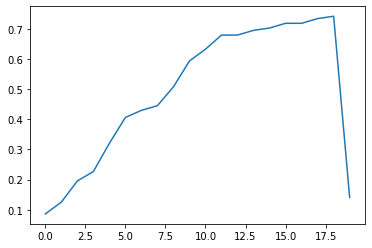

In [53]:
plt.plot(accs)

In [54]:
ops = np.array([count_ops(model, c + 1.0) for c in cycles])

In [58]:
ops.shape

(20, 8)

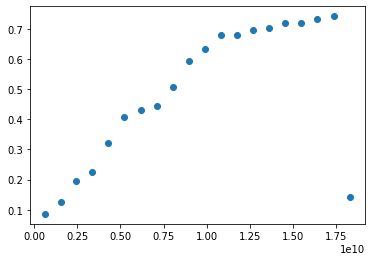

In [59]:
plt.scatter(ops.sum(axis=1), accs)

In [67]:
results = {"synaptic_ops": ops.sum(axis=1), "accuracy": accs, "ann_reference": static_acc}

In [68]:
np.savez_compressed("runs/conv_phasor_ops.npz", **results)

In [43]:
x = ops.sum()

In [44]:
x

18272014746.0

In [45]:
np.format_float_scientific(x)

'1.8272014746e+10'

In [29]:
model.input_spikes

ListWrapper([(<tf.Tensor: shape=(3, 61440), dtype=int64, numpy=
array([[ 0,  0,  0, ..., 31, 31, 31],
       [ 0,  0,  0, ..., 31, 31, 31],
       [ 0,  1,  2, ...,  0,  1,  2]])>, <tf.Tensor: shape=(61440,), dtype=float32, numpy=
array([ 0.27014992,  0.8044724 ,  0.7205596 , ..., 19.73339   ,
       19.804472  , 19.717562  ], dtype=float32)>), (<tf.Tensor: shape=(3, 61440), dtype=int64, numpy=
array([[ 0,  0,  0, ..., 31, 31, 31],
       [ 0,  0,  0, ..., 31, 31, 31],
       [ 0,  1,  2, ...,  0,  1,  2]])>, <tf.Tensor: shape=(61440,), dtype=float32, numpy=
array([ 0.32265046,  0.8874712 ,  0.8674611 , ..., 19.668537  ,
       19.657629  , 19.59914   ], dtype=float32)>), (<tf.Tensor: shape=(3, 61440), dtype=int64, numpy=
array([[ 0,  0,  0, ..., 31, 31, 31],
       [ 0,  0,  0, ..., 31, 31, 31],
       [ 0,  1,  2, ...,  0,  1,  2]])>, <tf.Tensor: shape=(61440,), dtype=float32, numpy=
array([ 0.2238259,  0.8789585,  0.7745234, ..., 19.887804 , 20.015162 ,
       19.865963 ], dtype=flo

In [27]:
len(model.pool1_spikes)

128

In [28]:
model.count_ops(10.0)

AttributeError: 'Conv2DPhasorModel' object has no attribute 'input_spks'

In [32]:
#run from saved results (can resume from here when results are saved)

In [33]:
trueys = np.load("runs/matching_ys.npz")['a']
trueys = y_test[0:n_subsample,...]

In [34]:
#the true matching labels
trueys

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([7, 0, 0, 2, 9, 2, 7, 6, 1, 3, 8, 2, 8, 8, 3, 1, 7, 0, 9, 0, 4, 2,
       6, 5, 3, 1, 5, 3, 5, 0, 0, 3, 2, 5, 5, 7, 8, 5, 7, 7, 8, 2, 8, 8,
       7, 0, 8, 3, 1, 5, 2, 5, 1, 0, 0, 8, 5, 9, 8, 2, 3, 8, 7, 6, 5, 0,
       5, 9, 2, 1, 0, 9, 0, 2, 3, 0, 5, 5, 1, 2, 6, 4, 3, 8, 2, 0, 2, 7,
       0, 8, 7, 3, 8, 6, 3, 4, 1, 0, 1, 1, 8, 2, 1, 1, 1, 4, 4, 5, 4, 2,
       4, 2, 4, 1, 8, 1, 0, 9, 4, 1, 1, 4, 3, 0, 4, 2, 8, 1])>

In [35]:
all_res = [np.load("runs/cifar_dyn_batch"+str(i)+".npz")["a"] for i in range(n_batches)]

In [36]:
#get the ouput phases for each sample, cycle, and neuron
dyn_yhs0 = tf.concat(all_res, axis=0)

In [37]:
dyn_yhs0.shape

TensorShape([128, 20, 10])

In [39]:
def predict_ind(phases, ind=-2):
    distance = tf.math.abs(phases - 0.5)
    indices = o2 = tf.math.argmin(distance, axis=2)
    selected = indices[:,ind]

    return selected

In [40]:
#use the predict function to get the class predicted by the last full cycle
dyn_yhs = predict_ind(dyn_yhs0, -2)

In [41]:
#the predicted labels from dynamic execution for each sample
dyn_yhs.shape

TensorShape([128])

In [42]:
dyn_yhs == trueys

<tf.Tensor: shape=(128,), dtype=bool, numpy=
array([False,  True,  True, False,  True, False,  True, False,  True,
       False, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True, False,  True, False, False,  True, False,
       False, False,  True,  True, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True, False,  True, False,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, Fal

In [43]:
#accuracy of predictions made at each cycle
#last 2 cycles this deep in the network are 'cut off' by the ending time (20.0s) and ignored
all_predictions = np.array([np.mean(predict_ind(dyn_yhs0, i) == trueys) for i in range(m_repeats-2)])

In [44]:
dpi=100

In [46]:
all_predictions.shape

(18,)

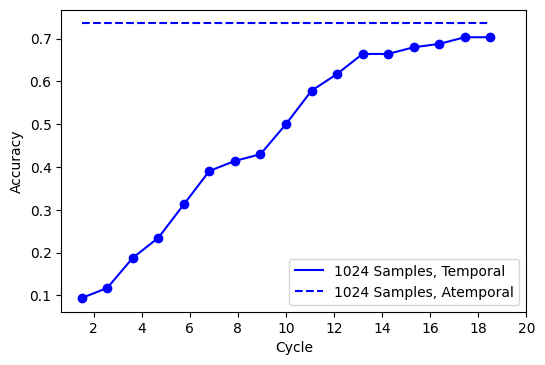

In [45]:
plt.figure(dpi=dpi)
plt.plot(1.5+np.linspace(0, 17 , 17), all_predictions[0:17], label="1024 Samples, Temporal",  color="blue")
plt.plot(1.5+np.linspace(0, 17 , 17), all_predictions[0:17], 'o',  color="blue")
plt.plot(1.5+np.linspace(0, 17 , 17), np.ones(17)*0.7353515625, "--", label="1024 Samples, Atemporal", color="blue")
plt.xticks(np.arange(2,21,2), np.arange(2,21,2))
plt.xlabel("Cycle")
plt.ylabel("Accuracy")
plt.legend()

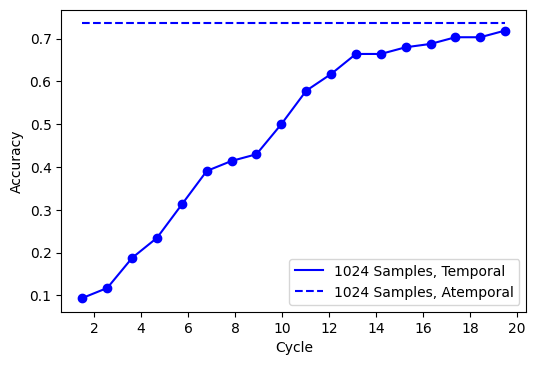

In [50]:
plt.figure(dpi=dpi)
plt.plot(1.5+np.linspace(0, 18 , 18), all_predictions, label="1024 Samples, Temporal",  color="blue")
plt.plot(1.5+np.linspace(0, 18 , 18), all_predictions, 'o',  color="blue")
plt.plot(1.5+np.linspace(0, 18 , 18), np.ones(18)*0.7353515625, "--", label="1024 Samples, Atemporal", color="blue")
plt.xticks(np.arange(2,21,2), np.arange(2,21,2))
plt.xlabel("Cycle")
plt.ylabel("Accuracy")
plt.legend()

In [25]:
np.savez_compressed("1024_dyn.npz", a=all_predictions)

In [53]:
model.summary()

Model: "conv2d_phasor_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo multiple                  12        
_________________________________________________________________
cmpx_conv2d (CmpxConv2D)     multiple                  864       
_________________________________________________________________
cmpx_conv2d_1 (CmpxConv2D)   multiple                  9216      
_________________________________________________________________
dropout1 (Dropout)           multiple                  0         
_________________________________________________________________
cmpx_conv2d_2 (CmpxConv2D)   multiple                  18432     
_________________________________________________________________
cmpx_conv2d_3 (CmpxConv2D)   multiple                  36864     
_________________________________________________________________
dropout2 (Dropout)           multiple          

In [66]:
x_subset = x_test[0:128,...]

In [60]:
def get_dynamic_input(model, inputs):
    x = model.project_fn(inputs)
    x = model.batchnorm(x)
    #convert continuous time representations into periodic spike train
    s = phase_to_train(x, shape=model.image_shape, period=model.dyn_params["period"], repeats=model.repeats)

    return s

In [67]:
inp = get_dynamic_input(model, x_subset)

In [64]:
def count_spikes(model, input_spks, time):
    count_lambda = lambda x: np.sum(x[1] < time)
    #get the average, cumulative number of input spikes at the current time
    input_sum = np.mean(list(map(count_lambda, input_spks)))
    #get the average, cumulative number of internal spikes for each layer
    conv1_sum = np.mean(list(map(count_lambda, model.conv1.spike_trains)))
    conv2_sum = np.mean(list(map(count_lambda, model.conv2.spike_trains)))
    conv3_sum = np.mean(list(map(count_lambda, model.conv3.spike_trains)))
    conv4_sum = np.mean(list(map(count_lambda, model.conv4.spike_trains)))
    dense1_sum = np.mean(list(map(count_lambda, model.dense1.spike_trains)))

    return np.array([input_sum, 
        conv1_sum,
        conv2_sum,
        conv3_sum,
        conv4_sum,
        dense1_sum])

In [80]:
inp[0]

(<tf.Tensor: shape=(3, 61440), dtype=int64, numpy=
 array([[ 0,  0,  0, ..., 31, 31, 31],
        [ 0,  0,  0, ..., 31, 31, 31],
        [ 0,  1,  2, ...,  0,  1,  2]])>,
 <tf.Tensor: shape=(61440,), dtype=float32, numpy=
 array([ 0.2238259,  0.8789585,  0.7745234, ..., 19.887804 , 20.015162 ,
        19.865963 ], dtype=float32)>)

In [82]:
count_spikes(model, inp, 0.5)

array([1471.6640625, 4635.328125 , 1620.6328125,    0.       ,
          0.       ,    0.       ])

In [81]:
np.sum(inp[0][1] < 0.5)

1465

In [83]:
count_spikes(model, inp, 1.5)

array([ 4543.6640625, 30240.6953125, 28552.765625 ,  8924.046875 ,
        6199.578125 ,   566.4453125])

In [84]:
np.sum(inp[0][1] < 1.5)

4537

In [70]:
count_spikes(model, inp, 1.5)

array([ 4543.6640625, 30240.6953125, 28552.765625 ,  8924.046875 ,
        6199.578125 ,   566.4453125])

In [70]:
count_spikes(model, inp, 1.5)

array([ 4543.6640625, 30240.6953125, 28552.765625 ,  8924.046875 ,
        6199.578125 ,   566.4453125])

In [71]:
spk_sum = np.array([count_spikes(model, inp, t) for t in np.linspace(0, 20.0, 201)])

In [85]:
spk_sum.shape

(201, 6)

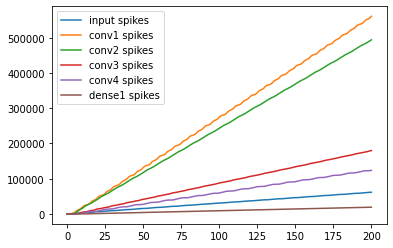

In [87]:
plt.plot(spk_sum[:,0], label="input spikes")
plt.plot(spk_sum[:,1], label="conv1 spikes")
plt.plot(spk_sum[:,2], label="conv2 spikes")
plt.plot(spk_sum[:,3], label="conv3 spikes")
plt.plot(spk_sum[:,4], label="conv4 spikes")
plt.plot(spk_sum[:,5], label="dense1 spikes")
plt.legend()

In [74]:
def count_ops(model, inp, time):
    #compute the fanout for each layer receiving inputs
    conv1_fanout = np.prod(model.conv1.output_shape2)
    conv2_fanout = np.prod(model.conv2.output_shape2)
    conv3_fanout = np.prod(model.conv3.output_shape2)
    conv4_fanout = np.prod(model.conv4.output_shape2)
    dense1_fanout = np.prod(model.dense1.output_shape2)
    dense2_fanout = np.prod(model.dense2.output_shape2)

    fanout = np.array([conv1_fanout, 
        conv2_fanout,
        conv3_fanout,
        conv4_fanout,
        dense1_fanout,
        dense2_fanout])

    spk_ops = count_spikes(model, inp, time)
    syn_ops = spk_ops * fanout

    return syn_ops

In [77]:
count_ops(model, inp, 0.5)

array([4.23839250e+07, 1.16291112e+08, 1.49357520e+07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [75]:
count_ops(model, inp, 1.5)

array([1.30857525e+08, 7.58678564e+08, 2.63142288e+08, 5.71139000e+07,
       6.19957812e+06, 5.66445312e+03])

In [76]:
count_ops(model, inp, 20)

array([1.76871915e+09, 1.40793617e+10, 4.55476313e+09, 1.15210930e+09,
       1.23678148e+08, 1.90506172e+05])

In [ ]:
#compute the matching static accuracy

In [60]:
test_x, test_y = get_raw_dat(ds_test)

In [61]:
first_1024x = test_x[0:128,...]
first_1024y = test_y[0:128,...]

In [62]:
stat_y = model.call(first_1024x)

In [63]:
statys = model.predict(stat_y)

In [65]:
static_acc = np.mean(first_1024y == statys)

In [66]:
static_acc

0.7578125

In [95]:
#the dynamic CIFAR accuracy

In [96]:
dyn_a = np.mean(dyn_yhs == trueys)

In [97]:
statys

<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([1, 1, 9, ..., 4, 3, 4])>

In [98]:
stat_a = tf.reduce_mean(tf.cast(statys == first_1024y, dtype="float"))

In [99]:
#the static CIFAR accuracy

In [100]:
stat_a

<tf.Tensor: shape=(), dtype=float32, numpy=0.73339844>

In [101]:
#the accuracy loss

In [102]:
stat_a - dyn_a

<tf.Tensor: shape=(), dtype=float32, numpy=0.034179688>